In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='61e66ef3-1412-47e4-996d-0a8bff9a9e51', project_access_token='p-72115706f5129ed26287fc1d95314d0ca4f6f95d')
pc = project.project_context


# MARATONA BEHIND THE CODE 2020

## DESAFIO 6 - ANAHUAC

### Introducción

En este desafio, usted usará herramientas de IBM como Watson Studio (o Cloud Pak for Data) para construir un modelo baseado en Machine Learning capaz de preveer si un estudante irá continuar o abandonará su curso.

<hr>

## Installing Libs

In [2]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 6.8MB 8.7MB/s eta 0:00:01
     |████████████████████████████████| 307kB 39.1MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement numpy>=1.16.4, but you'll have numpy 1.15.4 which is incompatible.
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
ERROR: autoai-libs 1.10.5 has requirement scikit-learn==0.20.3, but you'll have scikit-learn 0.23.2 which is incompatible.
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [3]:
!pip install xgboost --upgrade

     |████████████████████████████████| 148.9MB 48.3MB/s eta 0:00:01


In [4]:
!pip install seaborn --upgrade

     |████████████████████████████████| 225kB 9.5MB/s eta 0:00:01
  Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0


In [5]:
!pip install graphviz

In [6]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 7.9MB/s eta 0:00:01


<hr>

## Loading the .csv dataset from GitHub

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


In [8]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/ForTraining.csv
df_base_for_training = pd.read_csv(r'ForTraining.csv')
df_base_for_training.head()

--2020-09-03 22:42:38--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/ForTraining.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92376 (90K) [text/plain]
Saving to: ‘ForTraining.csv’

100%[======================================>] 92,376      --.-K/s   in 0.005s  

2020-09-03 22:42:38 (18.3 MB/s) - ‘ForTraining.csv’ saved [92376/92376]



,studentId,reducido,ciclo,Graduado
0,88588.0,Interv. Edu.,2019 - 08,No
1,81135.0,Educacion,2019 - 05,Si
2,80926.0,Direc. Estrat. Neg,2019 - 05,Si
3,82415.0,B. I.,2019 - 06,Si
4,90082.0,Est. Temprana,2019 - 08,No


In [9]:
df_base_for_training.shape

(2500, 4)

In [10]:
df_base_for_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
studentId    2500 non-null float64
reducido     2500 non-null object
ciclo        2500 non-null object
Graduado     2500 non-null object
dtypes: float64(1), object(3)
memory usage: 78.2+ KB


Descripción: La primera tabla mostrada arriba tiene 4 columnas, 3 son features and el target: `Graduado` that has a binary values={Si, No}.

Usted puede, y debe, usar mas data que esta disponible para construir su modelo. Los siguientes archivos .csv presentados:

In [11]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/OrdenMaterias.csv
df_orden_materias = pd.read_csv(r'OrdenMaterias.csv')
df_orden_materias.head()

--2020-09-03 22:42:39--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/OrdenMaterias.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63920 (62K) [text/plain]
Saving to: ‘OrdenMaterias.csv’

100%[======================================>] 63,920      --.-K/s   in 0.003s  

2020-09-03 22:42:39 (18.4 MB/s) - ‘OrdenMaterias.csv’ saved [63920/63920]



,reducido,2017 - 03,2017 - 04,2017 - 05,2017 - 06,2017 - 07,2017 - 08,2018 - 01,2018 - 02,2018 - 03,...,2019 - 05,2019 - 06,2019 - 07,2019 - 08,2020 - 01,2020 - 02,2020 - 03,2020 - 04,2020 - 05,2020 - 06
0,Act. Derecho Contratual,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Sin clase,Sin clase,Sin clase,Sin clase,Consentimiento y objeto digital contractual,Métodos alternos de resolución de controversias,Nueva clasificación contractual,Nuevo derecho probatorio documental,Contratos inteligentes,Consentimiento y objeto digital contractual
1,Adm. Emp.,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Mercadotecnia Estratégica,Contabilidad Financiera y Presupuestos,Administración de costos,Impuestos,Desafíos actuales en la Dirección del Capital ...,Mercadotecnia Estratégica,Contabilidad Financiera y Presupuestos,Administración de costos,Impuestos,Desafíos actuales en la Dirección del Capital ...
2,Adm. Riesgos,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Riesgos empresariales,Contabilidad Financiera y Presupuestos,Administración de riesgos,Evaluación de Riesgos,Toma de Decisiones,Riesgos empresariales,Contabilidad Financiera y Presupuestos,Administración de riesgos,Evaluación de Riesgos,Toma de Decisiones
3,Adm. Salud,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Calidad en salud,Contabilidad Financiera y Presupuestos,Administración de costos,Salud pública,Planeación estratégica en salud,Calidad en salud,Contabilidad Financiera y Presupuestos,Planeación estratégica en salud,Salud pública,Planeación estratégica en salud
4,Admon Fin.,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,...,Decisión y Análisis de Inversión,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...,Decisión y Análisis de Inversión,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...


In [12]:
df_orden_materias.drop(['2017 - 03','2017 - 04','2017 - 05','2017 - 06','2017 - 07','2017 - 08','2018 - 01','2018 - 02','2018 - 03','2018 - 04','2018 - 05','2018 - 06','2018 - 07','2018 - 08'], axis=1, inplace = True)

In [13]:
df_orden_materias.head()

,reducido,2019 - 01,2019 - 02,2019 - 03,2019 - 04,2019 - 05,2019 - 06,2019 - 07,2019 - 08,2020 - 01,2020 - 02,2020 - 03,2020 - 04,2020 - 05,2020 - 06
0,Act. Derecho Contratual,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Consentimiento y objeto digital contractual,Métodos alternos de resolución de controversias,Nueva clasificación contractual,Nuevo derecho probatorio documental,Contratos inteligentes,Consentimiento y objeto digital contractual
1,Adm. Emp.,Sin clase,Sin clase,Sin clase,Sin clase,Mercadotecnia Estratégica,Contabilidad Financiera y Presupuestos,Administración de costos,Impuestos,Desafíos actuales en la Dirección del Capital ...,Mercadotecnia Estratégica,Contabilidad Financiera y Presupuestos,Administración de costos,Impuestos,Desafíos actuales en la Dirección del Capital ...
2,Adm. Riesgos,Sin clase,Sin clase,Sin clase,Sin clase,Riesgos empresariales,Contabilidad Financiera y Presupuestos,Administración de riesgos,Evaluación de Riesgos,Toma de Decisiones,Riesgos empresariales,Contabilidad Financiera y Presupuestos,Administración de riesgos,Evaluación de Riesgos,Toma de Decisiones
3,Adm. Salud,Sin clase,Sin clase,Sin clase,Sin clase,Calidad en salud,Contabilidad Financiera y Presupuestos,Administración de costos,Salud pública,Planeación estratégica en salud,Calidad en salud,Contabilidad Financiera y Presupuestos,Planeación estratégica en salud,Salud pública,Planeación estratégica en salud
4,Admon Fin.,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...,Decisión y Análisis de Inversión,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...,Decisión y Análisis de Inversión,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...


In [14]:
df_orden_materias['2020 - 02'].value_counts()

Sin clase                                                                                         12
Mercadotecnia Estratégica                                                                          6
Desarrollo humano                                                                                  5
Marketing Analytics                                                                                4
Negocios digitales                                                                                 4
Análisis y solución de casos                                                                       3
Planeación Estratégica del Capital Humano                                                          3
Decisión y Análisis de Inversión                                                                   3
Gestión de Centros Educativos                                                                      2
Contratos inteligentes                                                                     

In [15]:
df_orden_materias.shape

(115, 15)

In [16]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaConexiones.csv
df_tabla_conexiones = pd.read_csv(r'TablaConexiones.csv')
df_tabla_conexiones.head()

--2020-09-03 22:42:40--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaConexiones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243492 (238K) [text/plain]
Saving to: ‘TablaConexiones.csv’

100%[======================================>] 243,492     --.-K/s   in 0.01s   

2020-09-03 22:42:40 (21.0 MB/s) - ‘TablaConexiones.csv’ saved [243492/243492]



,studentId,ciclo,Dias_Conectado,Minutos_Promedio,Minutos_Total
0,45870,2017 - 03,10.0,76.957000,769.57
1,45898,2017 - 03,32.0,370.231250,11847.40
2,45905,2017 - 03,50.0,198.717400,9935.87
3,45931,2017 - 03,22.0,294.535909,6479.79
4,45933,2017 - 03,18.0,177.991667,3203.85


In [17]:
df_tabla_conexiones.shape

(4496, 5)

In [18]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaTareas.csv
df_tabla_tareas = pd.read_csv(r'TablaTareas.csv')
df_tabla_tareas.head()

--2020-09-03 22:42:41--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaTareas.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 310923 (304K) [text/plain]
Saving to: ‘TablaTareas.csv’

100%[======================================>] 310,923     --.-K/s   in 0.01s   

2020-09-03 22:42:42 (22.1 MB/s) - ‘TablaTareas.csv’ saved [310923/310923]



,studentId,ciclo,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
0,81328.0,2019 - 05,99.000000,10.0,0.0,0.0,10.0
1,99206.0,2020 - 02,80.777500,10.0,2.0,0.0,12.0
2,94582.0,2020 - 01,79.666000,10.0,0.0,0.0,10.0
3,87564.0,2019 - 07,0.000000,0.0,15.0,0.0,15.0
4,87971.0,2019 - 08,36.363636,5.0,6.0,0.0,11.0


In [19]:
df_tabla_tareas.shape

(6298, 7)

Overview del Dataset:

    Disponibles para el participante, ecisten 4 tables cargas en DataFrames anteriormente:
    
    **df_base_for_training**
        - ``studentId``
        ``reducido``
        ``ciclo``
        ``Graduado`` --> ¡LA VARIABLE OBJETIVO PARA CLASIFICACIÓN BINARIA!
        
    **df_orden_materias**
        ``reducido``
        ``2017 - 03``
        ``2017 - 04``
        ``2017 - 05``
        ``2017 - 06``
        ``2017 - 07``
        ``2017 - 08``
        ``2018 - 01``
        ``2018 - 02``
        ``2018 - 03``
        ``2018 - 04``
        ``2018 - 05``
        ``2018 - 06``
        ``2018 - 07``
        ``2018 - 08``
        ``2019 - 01``
        ``2019 - 02``
        ``2019 - 03``
        ``2019 - 04``
        ``2019 - 05``
        ``2019 - 06``
        ``2019 - 07``
        ``2019 - 08``
        ``2020 - 01``
        ``2020 - 02``
        ``2020 - 03``
        ``2020 - 04``
        ``2020 - 05``
        ``2020 - 06``
        
    **df_tabla_conexiones**
        - ``studentId``
        ``ciclo``
        ``Dias_Conectado``
        ``Minutos_Promedio``
        ``Minutos_Total``
        
    **df_tabla_tareas**
        - ``studentId``
        ``ciclo``
        ``Calificacion_Promedio``
        ``Tareas_Puntuales``
        ``Tareas_No_Entregadas``
        ``Tareas_Retrasadas``
        ``Total_Tareas``
        
Observe que la variable ``studentId`` aparece en varias tablas.

Usted puede combinar/merge estos datasets como usted desee.

In [20]:
print("Columnas en *df_base_for_training*:")
print(df_base_for_training.columns)

print("\Columnas en *df_orden_materias*:")
print(df_orden_materias.columns)

print("\Columnas en *df_tabla_conexiones*:")
print(df_tabla_conexiones.columns)

print("\Columnas en *df_tabla_tareas*:")
print(df_tabla_tareas.columns)

Columnas en *df_base_for_training*:
Index(['studentId', 'reducido', 'ciclo', 'Graduado'], dtype='object')
\Columnas en *df_orden_materias*:
Index(['reducido', '2019 - 01', '2019 - 02', '2019 - 03', '2019 - 04',
       '2019 - 05', '2019 - 06', '2019 - 07', '2019 - 08', '2020 - 01',
       '2020 - 02', '2020 - 03', '2020 - 04', '2020 - 05', '2020 - 06'],
      dtype='object')
\Columnas en *df_tabla_conexiones*:
Index(['studentId', 'ciclo', 'Dias_Conectado', 'Minutos_Promedio',
       'Minutos_Total'],
      dtype='object')
\Columnas en *df_tabla_tareas*:
Index(['studentId', 'ciclo', 'Calificacion_Promedio', 'Tareas_Puntuales',
       'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas'],
      dtype='object')


#### ¡ATENCIÓN! La columna **target** es  ``Graduado``, presente en el DataFrame "df_base_for_training".

<hr>

## Uniendo DataFrames en Pandas

Documentación oficial para Pandas 1.1.0: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

Como un **ejemplo** de como usar Pandas, camos a unir/merge la información de las tablas "df_base_for_training" y "df_tabla_tareas" a traves de la llave ``studentId``.

Usted puee editar el dataframes manualmente si lo prefiere, usando Microsoft Excel u otros lenguajes. Recuerde insertar la data procesada en IBM Cloud Pak for Data para que pueda entrenar su modelo.

In [21]:
df_base_for_training.tail()

,studentId,reducido,ciclo,Graduado
2495,89685.0,Estrat. Comercial,2019 - 08,No
2496,77590.0,Crianza Hijos,2019 - 06,Si
2497,57623.0,Mercadotecnia,2018 - 02,Si
2498,50018.0,Lider. Inst. Edu.,2017 - 05,No
2499,88250.0,Prof. Deportiva.,2019 - 08,No


In [22]:
df_tabla_tareas.tail()

,studentId,ciclo,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
6293,80467.0,2019 - 05,20.000000,1.0,4.0,0.0,5.0
6294,80249.0,2019 - 05,50.600000,3.0,2.0,0.0,5.0
6295,85857.0,2019 - 07,81.428571,13.0,1.0,0.0,14.0
6296,98880.0,2020 - 02,91.212727,11.0,0.0,0.0,11.0
6297,71859.0,2019 - 02,87.333000,10.0,0.0,0.0,10.0


In [23]:
df_tabla_conexiones.tail()

,studentId,ciclo,Dias_Conectado,Minutos_Promedio,Minutos_Total
4491,91335,2019 - 08,102.0,256.105686,26122.78
4492,91345,2019 - 08,6.0,14.650000,87.90
4493,91346,2019 - 08,26.0,230.841538,6001.88
4494,91414,2019 - 08,46.0,257.319130,11836.68
4495,91437,2019 - 08,42.0,112.868333,4740.47


In [24]:
# El resultado de esta celda sera la union de los dos anteriores dataframes
# usando la columna ``studentId`` como llave.

df = pd.merge(
    df_base_for_training, df_tabla_tareas, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
    left_index=False, right_index=False, sort=True,
    suffixes=('_x', '_y'), copy=True, indicator=False,
    validate=None
)
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
2495,91320.0,Adm. Emp.,2019 - 08,No,71.818182,9.0,2.0,0.0,11.0
2496,91330.0,I. A.,2019 - 08,Si,81.333333,15.0,0.0,0.0,15.0
2497,91331.0,Gest. Esc.,2019 - 08,No,73.333333,9.0,0.0,0.0,9.0
2498,91335.0,Gest. Esc.,2019 - 08,Si,85.185556,9.0,0.0,0.0,9.0
2499,91346.0,Psicopat. Adol.,2019 - 08,No,80.159333,15.0,0.0,0.0,15.0


In [25]:
df = pd.merge(
    df, df_tabla_conexiones, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
    left_index=False, right_index=False, sort=True,
    suffixes=('_x', '_y'), copy=True, indicator=False,
    validate=None
)
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total
2495,91320.0,Adm. Emp.,2019 - 08,No,71.818182,9.0,2.0,0.0,11.0,21.0,468.019048,9828.40
2496,91330.0,I. A.,2019 - 08,Si,81.333333,15.0,0.0,0.0,15.0,90.0,431.348000,38821.32
2497,91331.0,Gest. Esc.,2019 - 08,No,73.333333,9.0,0.0,0.0,9.0,27.0,171.675926,4635.25
2498,91335.0,Gest. Esc.,2019 - 08,Si,85.185556,9.0,0.0,0.0,9.0,102.0,256.105686,26122.78
2499,91346.0,Psicopat. Adol.,2019 - 08,No,80.159333,15.0,0.0,0.0,15.0,26.0,230.841538,6001.88


In [26]:
# Información acerca de las columnas del dataset unido
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 12 columns):
studentId                2500 non-null float64
reducido                 2500 non-null object
ciclo                    2500 non-null object
Graduado                 2500 non-null object
Calificacion_Promedio    2500 non-null float64
Tareas_Puntuales         2500 non-null float64
Tareas_No_Entregadas     2500 non-null float64
Tareas_Retrasadas        2500 non-null float64
Total_Tareas             2500 non-null float64
Dias_Conectado           2500 non-null float64
Minutos_Promedio         2500 non-null float64
Minutos_Total            2500 non-null float64
dtypes: float64(9), object(3)
memory usage: 253.9+ KB


De la información de arriba ud puede observar que hay valores Null/NaN en algunas de las columnas.

Para que nuestro modelo quede bien entrenado necesitamos procesar estos valores nulos de una forma adecuada.

Usted escogera la mejor estrategia como parte del desafío, pero en la siguiente celda encuentra un **ejemplo** the como puede hacer este procesamiento usanto la libreria *scikit-learn*.

<hr>

## Pre-procesando el dataset antes de entrenar

### Borrando finlas con valores NaN

Usando el metodo Pandas DataFrame.dropna() usted puede remover todas las filas que estan indefinidas para la columna ``Graduado``.

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [27]:
# Visualizando los datos faltantes del dataset antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación DropNA: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos antes de la transformación DropNA: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
Dias_Conectado           0
Minutos_Promedio         0
Minutos_Total            0
dtype: int64



In [28]:
# Aplicando la función para borrar todas las filas con valor NaN en la columna ``Graduado``:
df2 = df.dropna(axis='index', how='any', subset=['Graduado'])

In [29]:
# Visualizando los datos faltantes del dataset antes de la primera transformación (SimpleImputer) (df_data_3)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
Dias_Conectado           0
Minutos_Promedio         0
Minutos_Total            0
dtype: int64



### Procesando valores NaN con SimpleImputer de sklearn

Para los otros valores NaN vamos a usar como **ejemplo** la sustitución por la constante 0. 

Usted puede escoger cualquier estrategia que crea que es la mejor para esto :)

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simpleimputer#sklearn.impute.SimpleImputer

In [30]:
from sklearn.impute import SimpleImputer
import numpy as np


# Creando un objeto ``SimpleImputer``
impute_zeros = SimpleImputer(
    missing_values=np.nan,  # Los valores faltantes son de tipo ``np.nan`` (estandar Pandas)
    strategy='constant',  # La estrategia escogida es reemplazar por una constante
    fill_value=0,  # La constante que será usada para reemmplazar los valores faltantes es un int64=0.
    verbose=0,
    copy=True
)

In [31]:
# Visualizando los datos faltantes del dataset antes de la segunda transformación (df_data_2)
print("Valores nulos antes de transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

# Aplicar la transformación ``SimpleImputer`` en el conjunto de datos base
impute_zeros.fit(X=df)

# Reconstrucción del nuevo DataFrame Pandas (df_data_3)
df = pd.DataFrame.from_records(
    data=impute_zeros.transform(
        X=df
    ),  # El resultado SimpleImputer.transform(<<pandas dataframe>>) es una lista de listas
    columns=df.columns  # Las columnas originals deben ser conservadas en esta transformación
)

# Visualizndo los datos faltantes del dataset 
print("Valores nulos del dataset despues de la transformación SimpleImputer: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos antes de transformación SimpleImputer: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
Dias_Conectado           0
Minutos_Promedio         0
Minutos_Total            0
dtype: int64

Valores nulos del dataset despues de la transformación SimpleImputer: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
Dias_Conectado           0
Minutos_Promedio         0
Minutos_Total            0
dtype: int64



### Eliminando columnas no desadas

Vamos a **demostrar** acontinuación como usar el metodo DataFrame.drop().

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

In [32]:
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total
2495,91320.0,Adm. Emp.,2019 - 08,No,71.818182,9.0,2.0,0.0,11.0,21.0,468.019048,9828.40
2496,91330.0,I. A.,2019 - 08,Si,81.333333,15.0,0.0,0.0,15.0,90.0,431.348000,38821.32
2497,91331.0,Gest. Esc.,2019 - 08,No,73.333333,9.0,0.0,0.0,9.0,27.0,171.675926,4635.25
2498,91335.0,Gest. Esc.,2019 - 08,Si,85.185556,9.0,0.0,0.0,9.0,102.0,256.105686,26122.78
2499,91346.0,Psicopat. Adol.,2019 - 08,No,80.159333,15.0,0.0,0.0,15.0,26.0,230.841538,6001.88


In [33]:
df["periodo"], df["dia"] = df["ciclo"].str.split("-", 1).str
df.drop(['reducido','ciclo'],axis=1,inplace=True)
df[['periodo','dia']] = df[['periodo','dia']].astype('float64')


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
studentId                2500 non-null float64
Graduado                 2500 non-null object
Calificacion_Promedio    2500 non-null float64
Tareas_Puntuales         2500 non-null float64
Tareas_No_Entregadas     2500 non-null float64
Tareas_Retrasadas        2500 non-null float64
Total_Tareas             2500 non-null float64
Dias_Conectado           2500 non-null float64
Minutos_Promedio         2500 non-null float64
Minutos_Total            2500 non-null float64
periodo                  2500 non-null float64
dia                      2500 non-null float64
dtypes: float64(11), object(1)
memory usage: 234.5+ KB


### Manejando variables Categoricas

Como se menciono antes, los computadores no son buenos con las variables categoricas.

Mientras que nosotros entendemos bien las variables categoricas, es debido a un conocimiento previo quie el computador no tiene.

La mayoria de tecnicas de Machine Learning y modelso trabajan con un set limitado de datos (Tipicamente binario). 

Las redes neurales consumenda data y producen resultados en el rango de 0..1 t raramente van mas alla del alcance.

En resumen, la gran mayoria de algoritmos de machine learning aceptan data de entrada  ("training data") de donde los features son extraidos.

Basado en estos features, un modelo matematico es creado, el cual es usado para hacer una predicción o decision sin ser programado explicitamente para esa tarea.

Dado un dataset con con 2 features, vamos a dejar que encoder encuentre los valores unicos por features y transforme la data a binario usando la tecnica one-hot encoding.

In [35]:
# Columnas One-hot-encoding del dataset usando el metodo de Pandas ``get_dummies``  (demontración)
#df3 = pd.get_dummies(df, columns=['ciclo'])
#df3.tail()

<hr>

## Entrenando un clasificador basado  en un Árbol de Decisión

### Seleccionando FEATURES y definiendo la variable TARGET

In [36]:
df.columns

Index(['studentId', 'Graduado', 'Calificacion_Promedio', 'Tareas_Puntuales',
       'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
       'Dias_Conectado', 'Minutos_Promedio', 'Minutos_Total', 'periodo',
       'dia'],
      dtype='object')

In [37]:
features = df[
    [
        'studentId','Calificacion_Promedio', 'Tareas_Puntuales',
       'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
       'Dias_Conectado', 'Minutos_Promedio', 'Minutos_Total', 'periodo',
       'dia'
    ]
]
target = df['Graduado']  ## No cambie la variable target!

### Dividiendo nuestro dataset en set de Entrenamiento y Pruebas

In [38]:
from sklearn.model_selection import train_test_split

#133
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

#Simplificar transformaciones con pipelines

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

model_scaled = make_pipeline(MinMaxScaler(),
                             LogisticRegression(C=1.0,penalty='l2',random_state=100,solver="newton-cg"))

model_scaled.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=100, solver='newton-cg'))])

In [40]:
# Método para creacion de modelos basados en arbol de desición
#from xbo import DecisionTreeClassifier
#dtc = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)

def run_model(X_train, X_test, y_train, y_test):
    model_scaled = LogisticRegression()
    model_scaled.fit(X_train, y_train)
    return model_scaled
 
model = run_model(X_train, X_test, y_train, y_test)
y_pred = model.predict(X_test)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.826\nPrecision=0.811\nRecall=0.875\nF1 Score=0.8421052631578947')

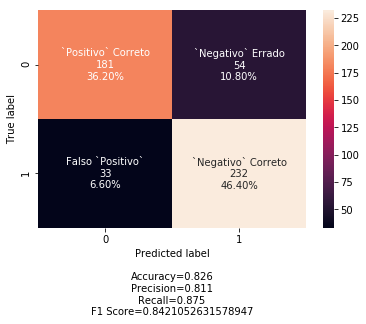

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

### Haciendo predicciones del Sample Test

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.85      0.77      0.81       235
          Si       0.81      0.88      0.84       265

    accuracy                           0.83       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.83      0.83      0.83       500



<hr>

## Scoring de la data requerida para hacer la entrega de la solución

Para el envío, necesita clasificar el siguiente dataset. Para hacer eso, usted necesita reproducir los mismos pasos de pre-procesamiento para que el dataset este en la misma estructura del que usted uso para construir su modelo. Despues de clasificar este dataframe, esperamos que usted entregue un archivo csv con las 2499 filar y una columna 'Graduado' con su predicción. **No cambie el orden del archivo a predecir ni borre filas**

In [43]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/for_submission/ToBePredicted.csv
df_to_be_predicted = pd.read_csv(r'ToBePredicted.csv')
df_to_be_predicted.tail()

--2020-09-03 22:42:44--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/for_submission/ToBePredicted.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33892 (33K) [text/plain]
Saving to: ‘ToBePredicted.csv’

100%[======================================>] 33,892      --.-K/s   in 0.002s  

2020-09-03 22:42:44 (20.8 MB/s) - ‘ToBePredicted.csv’ saved [33892/33892]



,studentId,reducido,ciclo
995,79594.0,Diagn. Psicoped.,2019 - 05
996,69470.0,Ventas Estrat.,2018 - 08
997,72921.0,Big Data,2019 - 02
998,80608.0,Interv. Psicoped,2019 - 05
999,86966.0,Interv. Psicoped,2019 - 07


In [44]:
df_to_be_predicted.shape

(1000, 3)

In [45]:
# Uniendo los dataset
df = pd.merge(
    df_to_be_predicted, df_tabla_tareas, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
    left_index=False, right_index=False, sort=True,
    suffixes=('_x', '_y'), copy=True, indicator=False,
    validate=None
)
df = pd.merge(
    df, df_tabla_conexiones, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
    left_index=False, right_index=False, sort=True,
    suffixes=('_x', '_y'), copy=True, indicator=False,
    validate=None
)
df.tail()



,studentId,reducido,ciclo,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total
995,91291.0,Trastornos Alimen.,2019 - 08,0.000,0.0,12.0,0.0,12.0,3.0,25.723333,77.17
996,91312.0,Marca Personal,2019 - 08,76.580,5.0,0.0,0.0,5.0,41.0,154.851951,6348.93
997,91329.0,Adm. Salud,2019 - 08,86.410,13.0,0.0,0.0,13.0,36.0,421.847222,15186.50
998,91345.0,Direc. Proy.,2019 - 08,0.000,0.0,9.0,0.0,9.0,6.0,14.650000,87.90
999,91437.0,Des. Neg. y Empren.,2019 - 08,75.024,15.0,0.0,0.0,15.0,42.0,112.868333,4740.47


In [46]:
df["periodo"], df["dia"] = df["ciclo"].str.split("-", 1).str
df.drop(['reducido','ciclo'],axis=1,inplace=True)
df[['periodo','dia']] = df[['periodo','dia']].astype('float64')


In [47]:
df.tail()

,studentId,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,periodo,dia
995,91291.0,0.000,0.0,12.0,0.0,12.0,3.0,25.723333,77.17,2019.0,8.0
996,91312.0,76.580,5.0,0.0,0.0,5.0,41.0,154.851951,6348.93,2019.0,8.0
997,91329.0,86.410,13.0,0.0,0.0,13.0,36.0,421.847222,15186.50,2019.0,8.0
998,91345.0,0.000,0.0,9.0,0.0,9.0,6.0,14.650000,87.90,2019.0,8.0
999,91437.0,75.024,15.0,0.0,0.0,15.0,42.0,112.868333,4740.47,2019.0,8.0


Observando los features declarados acontinuación, sabemos que el dataset ha ser evaluado esta en el mismo formato usado para entrenar nuestro árbol de decisión anteriormente.

```features = df3[
    [
        'studentId', 'Calificacion_Promedio', 'Tareas_Puntuales',
        'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
        'ciclo_2017 - 03', 'ciclo_2017 - 04', 'ciclo_2017 - 05',
        'ciclo_2017 - 06', 'ciclo_2017 - 07', 'ciclo_2017 - 08',
        'ciclo_2018 - 01', 'ciclo_2018 - 02', 'ciclo_2018 - 03',
        'ciclo_2018 - 04', 'ciclo_2018 - 05', 'ciclo_2018 - 06',
        'ciclo_2018 - 07', 'ciclo_2018 - 08', 'ciclo_2019 - 01',
        'ciclo_2019 - 02', 'ciclo_2019 - 03', 'ciclo_2019 - 04',
        'ciclo_2019 - 05', 'ciclo_2019 - 06', 'ciclo_2019 - 07',
        'ciclo_2019 - 08'
    ]
]
target = df3['Graduado']  ## No cambie la variable target!```

In [48]:
y_pred = model_scaled.predict(df[
    [
        'studentId','Calificacion_Promedio', 'Tareas_Puntuales',
       'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
       'Dias_Conectado', 'Minutos_Promedio', 'Minutos_Total', 'periodo',
       'dia'
    ]
])
print(y_pred)

['No' 'No' 'Si' 'Si' 'No' 'No' 'Si' 'No' 'No' 'No' 'Si' 'Si' 'No' 'Si'
 'Si' 'No' 'No' 'Si' 'Si' 'Si' 'No' 'No' 'Si' 'Si' 'No' 'No' 'Si' 'Si'
 'No' 'Si' 'Si' 'Si' 'No' 'Si' 'Si' 'No' 'No' 'No' 'Si' 'Si' 'Si' 'Si'
 'Si' 'Si' 'Si' 'Si' 'No' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'No'
 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si'
 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'No' 'Si' 'Si' 'No' 'Si' 'No' 'Si' 'No'
 'Si' 'Si' 'No' 'Si' 'No' 'No' 'No' 'No' 'Si' 'No' 'No' 'Si' 'Si' 'No'
 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'No' 'No' 'Si' 'Si' 'No' 'Si' 'No' 'Si'
 'Si' 'No' 'Si' 'Si' 'Si' 'No' 'No' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si' 'Si'
 'No' 'Si' 'Si' 'No' 'Si' 'Si' 'Si' 'Si' 'No' 'Si' 'Si' 'No' 'Si' 'Si'
 'Si' 'No' 'No' 'Si' 'Si' 'No' 'No' 'No' 'No' 'No' 'No' 'Si' 'Si' 'Si'
 'Si' 'Si' 'Si' 'Si' 'Si' 'No' 'No' 'Si' 'No' 'No' 'Si' 'No' 'Si' 'No'
 'No' 'Si' 'No' 'No' 'Si' 'Si' 'Si' 'Si' 'No' 'No' 'No' 'Si' 'Si' 'No'
 'No' 'No' 'Si' 'No' 'Si' 'No' 'Si' 'Si' 'Si' 'Si' 'No' 'Si' 'Si' 'No'
 'Si' 

### Guardando los resultados de la predicción en un archivo csv

In [49]:
np.savetxt("results.csv", y_pred, delimiter=",", fmt='%s')

In [50]:
project.save_data(file_name="results.csv", data=pd.read_csv("results.csv", header=None).to_csv(header=["TARGET"], index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'desafio6anahuac-donotdelete-pr-0altbxdgqshoku',
 'asset_id': '60f1f333-d906-4d4d-9be2-d148fe8a5ee2'}

<hr>

## ¡Felicitaciones!

Si todo fue ejecutado sin errores, usted ya tiene un modelo basado en classificacion binaria y puede descargar sus resultados para subirlos como csv!

Para enviar su solución, ve a la página:

# https://anahuac.maratona.dev
